# Python Learn By Doing - Producing an Application Map for Crop Treatment

**Author:** Lee Hathcock, Mississippi State University

This example is adapted from Pix4D's website. Pix4D's various products do orthomosaics and can also
automatically produce things like treatment maps for crops. But let's see if we can duplicate that
in Python without leaning on paid software!

https://community.pix4d.com/t/prescription-maps-for-variable-rate-application-pix4dfields-tutorials/23039

Note that we won't be doing the image-stitching portion for this workbook. There are free alternatives
available for photogrammetry, including OpenDroneMap (and the GUI version WebODM). While not as robust,
it has come a long way over the years.

## NDRE and NDVI Defined

### NDVI

Most folks in the agricultural field are aware of the Normalized Difference Vegetation Index (NDVI). This attempts
to capture the health of a plant via the NIR and Red bands. Healthy plants strongly absorb red light at the top of
the canopy, while NIR reflects very strongly. The ranges for NDVI are as follows:

| Value | Class |
|-----|-----|
| -1.0 to 0.0 | Dead/non-plants |
| 0.0 to 0.33 | Unhealthy plant |
|0.33 to 0.66 | Moderately healthy plant |
|0.66 to 1.0 | Very healthy plant |

## NDRE

Normalized Difference Red Edge Index (NDRE) replaces the red band with the red edge band, which is much more sensitive to leaf nitrogen content. It is
suitable for permanent or dense crops, and will be more accurate for crops almost ready for harvest. This is what
we're going to use for this application, although we're also going to visualize NDVI. Values look like the following:

| Value | Class |
|-----|-----|
| -1.0 to 0.1 | Bad/no N uptake |
| 0.1 to 0.3 | Weak N uptake |
| 0.3 to 0.4 | Moderate N uptake |
| 0.4 to 0.5 | Good N uptake |

In [1]:
# Bring in our libraries - GDAL and OSR for reading GeoTIFFs, NumPy for array
# manipulation, matplotlib for displaying imagery

import os, sys

from osgeo import gdal
from osgeo import osr
from osgeo import ogr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


## Opening the Image and Reading Cellsizes

Much like before, we open our image and get the geotransform and projection. This time, we
also want to go ahead and assign part of our geotransform, the x and y cellsizes, to
variables for later.

In [2]:
# Open the image file
img = gdal.Open("./data/lah1/2023-07-07_USDA_NACA_400ft_BGREN_DLS_11pTarp.tif")

# Get our image's geographic information
geotransform = img.GetGeoTransform()
wkt = img.GetProjection()
proj = osr.SpatialReference(wkt)

print (geotransform)

# While we don't have to, will be useful to assign our cell sizes to variables for later
xcellsize = geotransform[1]
ycellsize = geotransform[5]

(335059.29681, 0.08559999999999603, 0.0, 3705211.4425700004, 0.0, -0.08559999999996751)


This time, we're reading in just the bands we need, which for NDVI and NDRE are
red, red edge, and NIR, and putting them into NumPy arrays.

In [3]:
# Read in our bands. We're only going to grab what we need, so reading in
# red, red edge, and NIR.

# This will put the raster values for each band into a NumPy array.

red = img.GetRasterBand(3).ReadAsArray()
rededge = img.GetRasterBand(4).ReadAsArray()
nir = img.GetRasterBand(5).ReadAsArray()

Once again grab our NoData values.

In [4]:
# Get our nodata values

# This may actually change based on each band - probably not common, but
# still possible.

nodata = img.GetRasterBand(3).GetNoDataValue()
red = np.where(red == nodata, np.nan, red)
nodata = img.GetRasterBand(4).GetNoDataValue()
rededge = np.where(rededge == nodata, np.nan, rededge)
nodata = img.GetRasterBand(5).GetNoDataValue()
nir = np.where(nir == nodata, np.nan, nir)

In [5]:
# The easiest way to change the display scale for imagery is to change the DPI.
# The larger the number, the more it will slow things down.
plt.rcParams['figure.dpi'] = 150

Just as a sanity check, let's view the red band and make sure it imported correctly.

0.03983487
0.05990564


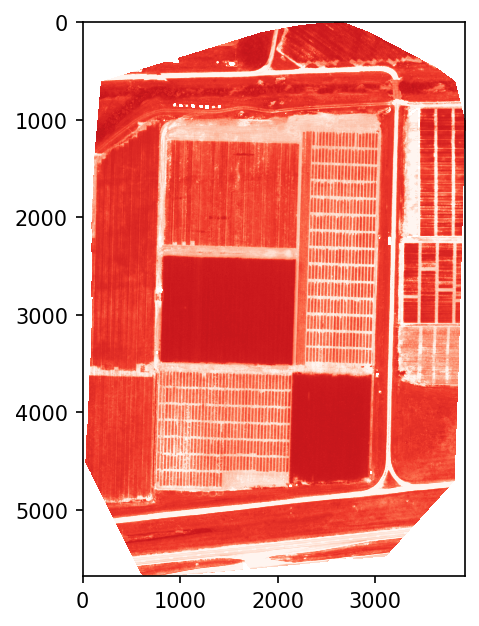

In [6]:
# Grab our standard deviation and mean. Will need it so we can scale our imagery
# more effectively. Currently using two standard deviations.
stdev = np.nanstd(red)
mean = np.nanmean(red)

print(stdev)
print(mean)

red_min_std = mean - (stdev*2)
red_max_std = mean + (stdev*2)

# This calls our normalization function. The color map can be changed in the imshow
# call - there are many built-in options, and custom color maps can also be used.
normalize = colors.Normalize(vmin=red_min_std, vmax=red_max_std, clip=True)
imred = plt.imshow(red, cmap='Reds_r', norm=normalize)

## Computing NDVI

We mentioned before that NDVI uses the Red and NIR bands. The formula should look quite familiar, as it
(and NDRE) are very similar to NDWI.

\begin{equation}
(NIR - Red) / (NIR + Red)
\end{equation}

Note that the places in dark green are very healthy crops, and the more yellow areas are potentially more
stressed crops. The red areas are primarily bare soil and roads.

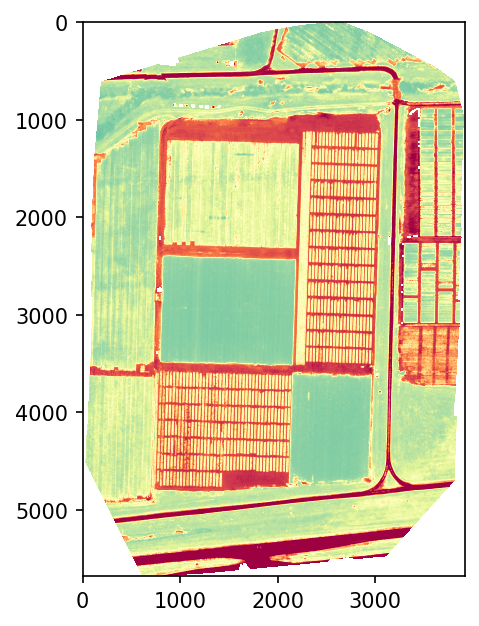

In [7]:
# Can compute NDVI if we're interesting in looking for vegetation.

# NDVI is (NIR - Red)/(NIR + Red)

ndvi = np.divide((nir - red),(nir + red))
stdev = np.nanstd(ndvi)
mean = np.nanmean(ndvi)

normalize = colors.Normalize(vmin=(mean - (stdev*2)), vmax=(mean + (stdev*2)), clip=True)
imndvi = plt.imshow(ndvi, cmap='Spectral', norm=normalize)

## Using the GDAL Warp Function

One thing we may wish to do is resize our imagery while still keeping the geographic extents. One
way to do this is via the "Warp" function, which takes an input GeoTIFF and takes various parameters
to alter it and push to a new GeoTIFF. (Note that when using VRTs, you can also skip pushing to an
intermediate file and store directly in memory.)

In our case, I'm going to decimate the image by a factor of five, as for what we're doing, we don't
need such fine-grained resolution.

In [8]:
# We need to create a temporary GeoTIFF file to store our results in. Be careful with this,
# as the rows and columns may be transposed from what the NumPy array holds currently.

driver = gdal.GetDriverByName('GTiff')
outdata = driver.Create('{}'.format("ndvi.tif"), ndvi.shape[1], ndvi.shape[0], 1, \
                        gdal.GDT_Float32, options=['COMPRESS=DEFLATE'])

# Write our modified classified array to the GeoTIFF we just created, and make sure to add
# in our georeferencing as well.
outdata.GetRasterBand(1).WriteArray(ndvi)
outdata.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
outdata.SetProjection(srs.ExportToWkt())
outdata.FlushCache()
outdata = None

# We don't necessarily want the full resolution of the GeoTIFF, so use the Warp function
# to reduce the resolution of the raster.

result = gdal.Warp("ndvi_lowres.tif", "ndvi.tif", xRes=xcellsize*5, yRes=ycellsize*5, resampleAlg="bilinear")

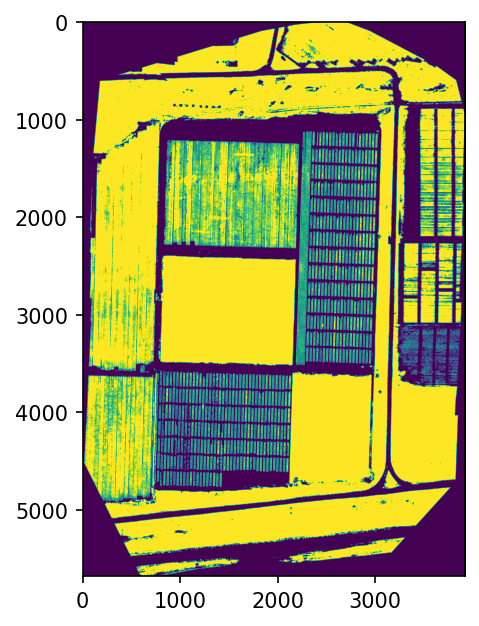

In [10]:
# Not necessary to write directly to files, but can go straight to memory with Warp.
result = gdal.Warp("", "ndvi.tif", format="VRT", outputType=gdal.GDT_Byte, xRes=xcellsize, yRes=ycellsize)
result_array = result.ReadAsArray()
plt.imshow(result_array)

## Computing NDRE

Once again, a familiar equation emerges, this time using red edge instead of red.

\begin{equation}
(NIR - Red Edge) / (NIR + Red Edge)
\end{equation}

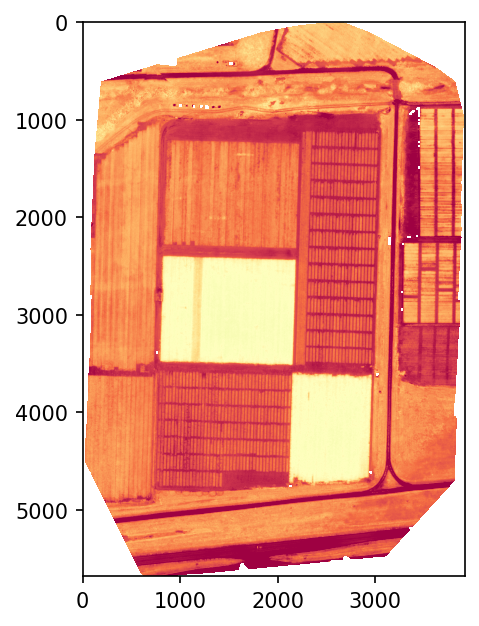

In [11]:
# Let's look at NDRE as well. This is more sensitive to nitrogen content.

# NDRE is (NIR - RedEdge)/(NIR + RedEdge)

ndre = np.divide((nir - rededge),(nir + rededge))
stdev = np.nanstd(ndvi)
mean = np.nanmean(ndvi)

normalize = colors.Normalize(vmin=(mean - (stdev*2)), vmax=(mean + (stdev*2)), clip=True)
imndre = plt.imshow(ndre, cmap='Spectral', norm=normalize)

Once again we resize our image.

In [12]:
# We need to create a temporary GeoTIFF file to store our results in. Be careful with this,
# as the rows and columns may be transposed from what the NumPy array holds currently.
driver = gdal.GetDriverByName('GTiff')
outdata = driver.Create('{}'.format("ndre.tif"), ndre.shape[1], ndre.shape[0], 1, \
                        gdal.GDT_Float32, options=['COMPRESS=DEFLATE'])

# Write our modified classified array to the GeoTIFF we just created, and make sure to add
# in our georeferencing as well.
outdata.GetRasterBand(1).WriteArray(ndre)
outdata.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
outdata.SetProjection(srs.ExportToWkt())
outdata.FlushCache()
outdata = None

# Reduce the resolution like last time to match.
result = gdal.Warp("ndre_lowres.tif", "ndre.tif", xRes=xcellsize*5, yRes=ycellsize*5, resampleAlg="bilinear")

## Using the NumPy select Command

Since we're doing more than a binary classification on this dataset, we will leverage
the NumPy "select" command, which lets us put together a list of conditions and choices
to assign values to each conditional. In this case, we're going to assign NaN to any
NDVI values less than zero, and then work through our NDRE conditional values for
NDVI values greater than zero.

In all technicality, the example Pix4D gave does not leverage NDVI at all, and it may
not make much difference here either. It is included for example purposes only.

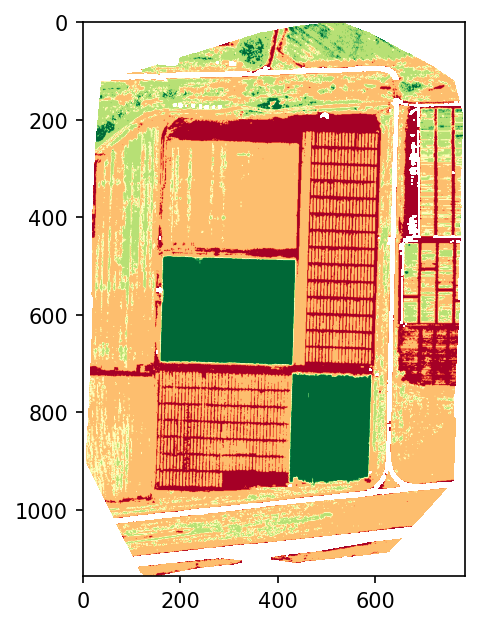

In [13]:
# There are different ranges that denote nitrogen uptake in NDRE.
# 0.1 - 0.3 - Poor N uptake
# 0.3 - 0.4 - Medium N uptake
# 0.4 - 0.5 - Good N uptake
# < 0.1 - Almost none/no uptake

# Open our generated NDVI/NDRE low-resolution files and put into arrays.
ndvi_img = gdal.Open('ndvi_lowres.tif')
ndvi = ndvi_img.GetRasterBand(1).ReadAsArray()
ndre_img = gdal.Open('ndre_lowres.tif')
ndre = ndre_img.GetRasterBand(1).ReadAsArray()

# Set up a conditional grouping so we can assign values based on our ranges.
# Setting NDVI values less than zero to NoData since we're only interested
# in plants.
conditions  = [ (ndvi <= 0),
                (ndre < 0.1) & (ndvi > 0),
                (ndre >= 0.1) & (ndre < 0.3) & (ndvi > 0), 
                (ndre >= 0.3) & (ndre < 0.4) & (ndvi > 0),
                (ndre >= 0.4) & (ndvi > 0) ]
choices     = [ np.nan, 1, 2, 3, 4 ]

classified = np.select(conditions, choices, default=np.nan)
imclass = plt.imshow(classified, cmap='RdYlGn')

Looking pretty good! We're still going to do a sieve filter because why not?

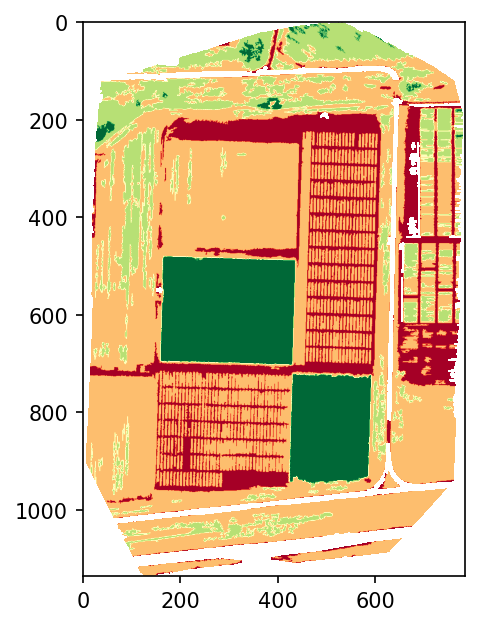

In [14]:
# Not necessarily needed since we've reduced resolution, but we may still want to filter
# the product a bit like we did the land/water mask.

# First, we're going to take everywhere that is a NumPy NaN and turn back to zero. This will
# effectively become our nodata value.
classified_nodata = np.where(np.isnan(classified), 0, classified)

# We need to create a temporary GeoTIFF file to store our results in. Be careful with this,
# as the rows and columns may be transposed from what the NumPy array holds currently.
driver = gdal.GetDriverByName('GTiff')
outdata = driver.Create('{}'.format("ndvi_ndre_filter.tif"), classified.shape[1], classified.shape[0], 1, \
                        gdal.GDT_Byte, options=['COMPRESS=DEFLATE'])

# Write our modified classified array to the GeoTIFF we just created, and make sure to add
# in our georeferencing as well.
outdata.GetRasterBand(1).WriteArray(classified_nodata)
outdata.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
outdata.SetProjection(srs.ExportToWkt())

# Now we're going to use GDAL's SieveFilter function to group pixels. There are several options to
# change here, but we will stick with a connectedness of 4 (don't consider diagonal pixels adjacent),
# and a threshold value of 50 (groups of pixels smaller than 50 will be disregarded).

gdal.SieveFilter(srcBand=outdata.GetRasterBand(1), maskBand=None, dstBand=outdata.GetRasterBand(1), threshold=50, connectedness=8)
outdata.GetRasterBand(1).SetNoDataValue(0)
outdata.FlushCache()

# Let's take a look at the results!
flt = gdal.Open("ndvi_ndre_filter.tif")
fltimg = flt.GetRasterBand(1).ReadAsArray()
nodata = flt.GetRasterBand(1).GetNoDataValue()
fltimg_nan = np.where(fltimg == nodata, np.nan, fltimg)
imflt = plt.imshow(fltimg_nan, cmap='RdYlGn')

## Choosing an Application Rate and Strategy

You can take two different approaches to treatment for this field: heterogeneous or
homogeneous. As Pix4D puts it, this is basically either Robin Hood or The Sheriff of
Nottingham.

### Homogenous (Robin Hood)

The idea is to take from the richer areas of the field and try to boost production in
areas that aren't terribly healthy.

### Heterogeneous (Sheriff of Nottingham)

In this case, we keep boosting the healthy plant areas and keep them rolling, effectively
taking from the poor to give to the rich.

Depending on the field, both of these are perfectly valid strategies to maximize yield.

#### Selecting zones generically

While we don't necessarily need to do it this way as we manually assigned classes above,
we can generically parse our fields for unique values to denote zones we will work with.
We're only really interested in three of our classes, though - values from 0.1 to 0.3,
values from 0.3 to 0.4, and values greater than 0.4.

Since there are NaN values in here, to get our average NDRE value for each zone (we'll need
it in a second), we use the "nanmean" function. We're also storing the arrays we get from
selecting each zone's values into a list, which we will then merge using the "concatenate"
function to get the field-wide average for only our zones of interest.

In [15]:
# Now let's compute our rates. Using two different approaches, Robin Hood and Sheriff of Nottingham.

# We're going with a base rate of 55 lbs of nitrogen per acre. (This is close to 60 kgN/ha, but I want
# Imperial units, thank you very much!)

# If we want to Robin Hood this thing, let's look at our average value for each zone.

zoneavg = []
extractarrays = []

# Let's look for our unique values. We technically already know this, but let's do it this way anyway.
unique_vals = np.unique(fltimg)
print(unique_vals)

for val in unique_vals:
    extract = ndre[fltimg == val]
    mean = np.nanmean(extract)
    if mean >= .1:
        zoneavg.append(mean)
        extractarrays.append(extract)
print (zoneavg)

extract_combined = np.concatenate(extractarrays)
fieldavg = np.nanmean(extract_combined)

print (fieldavg)

[0 1 2 3 4]
[0.22490096, 0.334162, 0.55432576]
0.2940604


## Computing Application Rates

### Homogenize (Robin Hood)

Now we're ready to rock with application rates. The formula for homogenization is defined as:

\begin{equation}
Rate_{zone} = (Rate_{flat} \color{red}- \color{black}[Rate_{flat} * ((NDRE_{ZoneAvg} - NDRE_{FieldAvg})/NDRE_{FieldAvg}) * Spread]
\end{equation}

We're starting with our flat rate (in this case 55 lbs/acre), and then adjusting based on the zone's average
compared to the field average and then multiplying by a spread function, which will exaggerate or lessen the
adjustments between zones. In this case, we're subtracting all that from the flat rate to take from the
best areas of the field and give more to the poor.

In [16]:
# Robin Hood algorithm (homogenize)

zonerate = []

spread = 0.75
flatrate = 55
for z in zoneavg:
    rate = flatrate - (flatrate * ((z - fieldavg)/fieldavg) * spread)
    zonerate.append(rate)
print (zonerate)

[64.70150038599968, 49.374657459557056, 18.49067948758602]


### Heterogenize (Sheriff)

The formula is virtually identical, but this time we add to the flat rate instead of subtracting to boost the
richest areas of the field further.

\begin{equation}
Rate_{zone} = (Rate_{flat} \color{YellowGreen}+ \color{black}[Rate_{flat} * ((NDRE_{ZoneAvg} - NDRE_{FieldAvg})/NDRE_{FieldAvg}) * Spread]
\end{equation}

In [17]:
# Sheriff (heterogenize)

zonerate = []

spread = 0.75
flatrate = 55
for z in zoneavg:
    rate = flatrate + (flatrate * ((z - fieldavg)/fieldavg) * spread)
    zonerate.append(rate)
print (zonerate)

[45.29849961400032, 60.625342540442944, 91.50932051241398]
